In [1]:
import copy
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
from scipy import interpolate as sciinterp
import skfmm
import getfem as gf
from getfem import *

import math

In [2]:
# plot level set
def plotLevelSet(x,y,lsp,lss,ax=None,cbar=True):
    if ax == None:
        fig, ax = plt.subplots(figsize=(8,5))
    X,Y = np.meshgrid(x,y)
    p = eval(lsp.replace('x','X').replace('y','Y'))
    c = ax.pcolormesh(x,y,p,shading='auto',cmap='RdBu_r',vmin=-1,vmax=1)
    cs = ax.contour(x,y,p,levels=[0],colors=[[0, 0, 0, 0]])
    p0 = cs.collections[0].get_paths()
    c_x = np.array([])
    c_y = np.array([])
    for p_i in p0:
        v = p_i.vertices
        c_x = np.append(c_x, v[:,0])
        c_y = np.append(c_y, v[:,1])
    if lss!=None:
        s = eval(lss.replace('x','c_x').replace('y','c_y'))
        c_x = c_x[s<=0]
        c_y = c_y[s<=0]
    ax.plot(c_x,c_y,'k')
    if cbar: 
        plt.colorbar(c,ax=ax,shrink=0.7)
    ax.set_aspect('equal')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title('level set')
    return ax, c_x, c_y, c

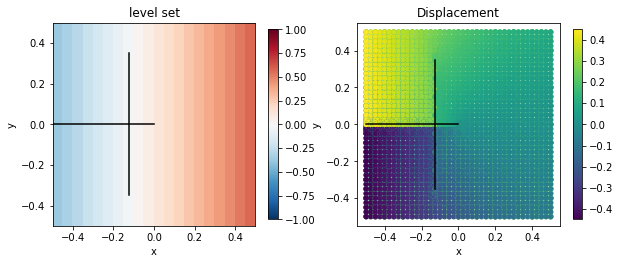

In [3]:
variant = 3
# variant : 1 : a single crack with cutoff enrichement
#           2 : a single crack with a fixed size area Xfem enrichment
#           3 : a supplementary crossing  crack with a fixed size area
#               Xfem enrichment
#           4 : variant 3 with the second crack closed by a penalisation of
#               the jump (example of use of xfem_plus and xfem_minus).
#           5 : variant 3 with the first crack closed by a penalisation of
#               the jump (example of use of xfem_plus and xfem_minus).
#           6 : variant 3 with the two cracks closed by a penalisation of
#               the jump (example of use of xfem_plus and xfem_minus).

# Parameters:  ######################
nx = 20                             #
ny = 20
Lx = 1
Ly = 1

# level sets where lsp = 0 and lss <= 0
# lss optional, set to None
ls1p = 'y'
ls1s = 'x'

ls2p = 'x+0.125'
ls2s = 'abs(y)-0.375'

DIRICHLET  = 101                    #
                                    #
Lambda = 1.25E10 # Lame coefficient #
Mu = 1.875E10    # Lame coefficient #
#####################################

x = np.linspace(-Lx/2,Lx/2,nx+1)
y = np.linspace(-Ly/2,Ly/2,ny+1)

# Mesh definition:
m = gf.Mesh('regular_simplices', x, y)
#m = gf.Mesh('import','gmsh','quad.msh')

# Boundary set:
m.set_region(DIRICHLET, m.outer_faces()) #label all outer faces as dirichlet condition

# Global functions for asymptotic enrichment:
ck0 = gf.GlobalFunction('crack',0)
ck1 = gf.GlobalFunction('crack',1)
ck2 = gf.GlobalFunction('crack',2)
ck3 = gf.GlobalFunction('crack',3)
if variant == 1: # Cutoff enrichement 
    coff = gf.GlobalFunction('cutoff',2,0.4,0.01,0.4)
    ckoff0 = ck0*coff # gf.GlobalFunction('product',ck0,coff)
    ckoff1 = ck1*coff
    ckoff2 = ck2*coff
    ckoff3 = ck3*coff

# Levelset definition:
ls = gf.LevelSet(m,1,ls1p,ls1s)
mls = gf.MeshLevelSet(m)
mls.add(ls)

fig, ax = plt.subplots(figsize=(10,5),ncols=2)
ax[0],c_x1,c_y1, c = plotLevelSet(x,y,ls1p,ls1s,ax=ax[0])
    
if variant > 2: # add second crack
    ls2 =  gf.LevelSet(m,1,ls2p,ls2s) # 1 is degree of mesh (regular simplices)
    mls.add(ls2);
    
    ax[0],c_x2,c_y2,c2 = plotLevelSet(x,y,ls2p,ls2s,ax=ax[0],cbar=False)
mls.adapt()

# Basic mesh_fem without enrichment:
mf_pre_u = gf.MeshFem(m)
mf_pre_u.set_fem(gf.Fem('FEM_PK(2,1)'))

# Definition of the enriched finite element method (MeshFemLevelSet):
mfls_u = gf.MeshFem('levelset',mls,mf_pre_u)

if variant == 1: # Cutoff enrichement 
    # MeshFemGlobalFunction:
    mf_sing_u = gf.MeshFem('global function',m,ls,[ckoff0,ckoff1,ckoff2,ckoff3],1)
    # MeshFemDirectSum:
    mf_u      = gf.MeshFem('sum',mf_sing_u,mfls_u)
else:
    mf_sing_u = gf.MeshFem('global function',m,ls,[ck0,ck1,ck2,ck3],1)
    mf_part_unity = gf.MeshFem(m)
    mf_part_unity.set_classical_fem(1)
    DOFpts = mf_part_unity.basic_dof_nodes()
    # Search the dofs to be enriched with the asymptotic displacement.
    Idofs_center = np.nonzero(np.square(DOFpts[0,:]) +
                             np.square(DOFpts[1,:]) <= 0.1**2)[0]
    mf_xfem_sing = gf.MeshFem('product', mf_part_unity, mf_sing_u)
    mf_xfem_sing.set_enriched_dofs(Idofs_center)
    if variant > 2:
        Idofs_up = np.nonzero(np.square(DOFpts[0,:]+0.125) +
                            np.square(DOFpts[1,:]-0.375) <= 0.1**2)[0]
        Idofs_down = np.nonzero(np.square(DOFpts[0,:]+0.125) +
                              np.square(DOFpts[1,:]+0.375) <= 0.1**2)[0]
        mf_sing_u2 = gf.MeshFem('global function',m,ls2,[ck0,ck1,ck2,ck3],1)
        mf_xfem_sing2 = gf.MeshFem('product', mf_part_unity, mf_sing_u2)
        mf_xfem_sing2.set_enriched_dofs(np.union1d(Idofs_up, Idofs_down))
    if variant == 2:
        mf_u = gf.MeshFem('sum', mf_xfem_sing, mfls_u)
    else:
        mf_u = gf.MeshFem('sum', mf_xfem_sing, mf_xfem_sing2, mfls_u)

mf_u.set_qdim(2)

# MeshIm definition (MeshImLevelSet):
mim = gf.MeshIm('levelset', mls, 'all',
        gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)'),
        gf.Integ('IM_STRUCTURED_COMPOSITE(IM_GAUSS_PARALLELEPIPED(2,6),9)'),
        gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),5)'))

# Exact solution for a single crack:
mf_ue = gf.MeshFem('global function',m,ls,[ck0,ck1,ck2,ck3])
A = 2+2*Mu/(Lambda+2*Mu); B=-2*(Lambda+Mu)/(Lambda+2*Mu)
Ue = np.zeros([2,4])
Ue[0,0] =   0; Ue[1,0] = A-B # sin(theta/2)
Ue[0,1] = A+B; Ue[1,1] = 0   # cos(theta/2)
Ue[0,2] =  -B; Ue[1,2] = 0   # sin(theta/2)*sin(theta)
Ue[0,3] =   0; Ue[1,3] = B   # cos(theta/2)*cos(theta)
Ue /= 2*np.pi
Ue = Ue.T.reshape(1,8)

# Model definition:
md = gf.Model('real')
md.add_fem_variable('u', mf_u)
# data
md.add_initialized_data('lambda', [Lambda])
md.add_initialized_data('mu', [Mu])
md.add_isotropic_linearized_elasticity_brick(mim,'u','lambda','mu')
md.add_initialized_fem_data("DirichletData", mf_ue, Ue)
md.add_Dirichlet_condition_with_penalization(mim,'u', 1e12, DIRICHLET, 'DirichletData')

if variant == 5 or variant == 6: # Penalisation of the jump over the first crack
    mim_bound1 = gf.MeshIm('levelset', mls, 'boundary(a)',
                          gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)'))
    #gf.asm_generic(mim_bound1, 0, '1', -1) # length of the crack
    md.add_linear_term\
    (mim_bound1, '1e17*(Xfem_plus(u)-Xfem_minus(u)).(Xfem_plus(Test_u)-Xfem_minus(Test_u))')

if variant == 4 or variant == 6: # Penalisation of the jump over the second crack
    mim_bound2 = gf.MeshIm('levelset', mls, 'boundary(b)',
                          gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)'))
    md.add_linear_term\
    (mim_bound2, '1e17*(Xfem_plus(u)-Xfem_minus(u)).(Xfem_plus(Test_u)-Xfem_minus(Test_u))')

# Assembly of the linear system and solve:
md.solve()
U = md.variable('u')

# Interpolation of the solution on a cut mesh for the drawing purpose
cut_mesh = mls.cut_mesh()
mfv = gf.MeshFem(cut_mesh, 2)
mfv.set_classical_discontinuous_fem(2, 0.001)
mf_ue.set_qdim(2)

V  = gf.compute_interpolate_on(mf_u, U, mfv)
Ve = gf.compute_interpolate_on(mf_ue, Ue, mfv)

# Computation of the Von Mises stress
mfvm = gf.MeshFem(cut_mesh)
mfvm.set_classical_discontinuous_fem(2, 0.001)
md.add_initialized_fem_data('u_cut', mfv, V)
VM = md.compute_isotropic_linearized_Von_Mises_or_Tresca('u_cut', 'lambda', 'mu', mfvm)

#mfv.export_to_pos('crack.pos', V, 'V', Ve, 'Ve', mfvm, VM, 'Von Mises')
D = mfv.basic_dof_nodes()
c1 = ax[1].scatter(D[0,:],D[1,:],20,V)
ax[1].plot(c_x1,c_y1,'k')
if variant > 2:
    ax[1].plot(c_x2,c_y2,'k')
plt.colorbar(c1,ax=ax[1],shrink=0.7)
ax[1].set_xlabel('x')
ax[1].set_ylabel('y')
ax[1].set_title('Displacement')
ax[1].set_aspect('equal')


In [11]:
# Define parameters

# mesh geometry
L_x = 10; L_y = 10; # length of boundaries
nx = 60; ny = 60; # number of elements
dx = L_x/nx; dy = L_y/ny
etype='cartesian'

# level sets where lsp = 0 and lss <= 0
# lss optional, set to None
ls1p = '(((x-5)*(x-5)+(y-5)*(y-5))-(1*1))'
ls1s = None

# pressure
p_atm = 0
rho1 = 10 # density where ls1p<0
rho2 = 1 # density where ls1p>0
mu2 = 1 # viscosity where ls1p>0
kappals = 1e-4 # numerical diffusion for level set stabilization

#forcing
f_x=None; f_y='-9.81*rho' # body forces
left_ux=0; left_uy=0; left_flux=None; 
right_ux=0; right_uy=0; right_flux=None; 
top_ux=0; top_uy=0; top_flux=None; 
bottom_ux=0; bottom_uy=0; bottom_flux=None;

# temperature
temp = False;
T0 = 1300 # temperature in deg C
kappa = 1e-5 # thermal diffusivity
Tatm = 600 # atmospheric temperature in deg C
stab = 'GLS' # None, SUPG, or GLS
fmm = True

mu_exp='min(exp(vfta + vftb/(T + 273 - vftc)),max_mu)'
#vfta = -4.605; vftb = 0; vftc = 0;
vfta = -4.55; vftb = 4901.9; vftc = 656.0; #For a typical basalt
max_mu=1e1

left_T=600; left_flux_T=None; right_T=600; right_flux_T=None; 
top_T=600; top_flux_T=None; bottom_T=800; bottom_flux_T=None;

# time discretization
tf = 0.005;
dt = 0.0001;

# output options
outfile='test'
vtk=False
plots=True

In [ ]:
# Mesh generation for structured quad elements
mesh = gf.Mesh(etype, np.linspace(0,L_x,nx+1), np.linspace(0,L_y,ny+1))

# outward vector in [x,y], tolerance angle theta (rad)
fb_left = mesh.outer_faces_with_direction([-1., 0.], 0.01)
fb_right = mesh.outer_faces_with_direction([ 1., 0.], 0.01)
fb_top = mesh.outer_faces_with_direction([0.,  1.], 0.01)
fb_bottom = mesh.outer_faces_with_direction([0., -1.], 0.01)

bounds = ['left','right','top','bottom']      
bounds_type = []
for i,bound in enumerate(bounds): 
    mesh.set_region(i+1, eval('fb_' + bound))
    if temp: 
        bounds_type = np.append(bounds_type,type(eval(bound + '_T')))
    else: 
        bounds_type = np.append(bounds_type,type(eval(bound + '_ux')))

if vtk:
    # export to vtk for visualization through python
    mesh.export_to_vtk(outfile + '/' + outfile+ '_mesh.vtk')

# Levelset definition:
ls = gf.LevelSet(mesh,1,ls1p,ls1s) # I think this is a 1 (scalar) vs vector field
mls = gf.MeshLevelSet(mesh)
mls.add(ls)
mls.adapt()
ls_init = ls.values(0)

if plots:
    # visualize mesh points in python
    fig1, ax = plt.subplots(figsize=(8,8))
    [x_ls,y_ls] = mls.cut_mesh().pts() # get nodes
    ax.scatter(x_ls,y_ls,50,'r',zorder=2) # plot nodes

    # plot all mesh edges (no overlap)
    for face in mls.cut_mesh().faces_from_cvid('merge').transpose():
        edge = mls.cut_mesh().pid_in_faces(CVFIDs=face)
        ax.plot(x_ls[edge], y_ls[edge],'k',zorder=0)

    # plot edges on BCs
    lr = True; lb = True;
    for bound in bounds:
        for face in eval('fb_' + bound).transpose():
            edge = mesh.pid_in_faces(CVFIDs=face)

            if temp: 
                bound_type = type(eval(bound + '_T'))
            else: 
                bound_type = type(eval(bound + '_ux'))
            if bound_type is not type(None):
                color = 'r' # plot Dirichlet bounds on temperature in red
                if temp: 
                    if lr: 
                        label = 'Temp BC'
                        lr = False
                    else: 
                        label = '_nolegend_'
                else: 
                    if lr: 
                        label = 'Vel BC'
                        lr = False
                    else:
                        label = '_nolegend_'
            else:
                color = 'b' # plot Dirichlet bounds on temperature in blue
                if lb: 
                    label = 'Flux BC'
                    lb = False
                else: 
                    label = '_nolegend_'

            [x0,y0] = mesh.pts()
            ax.plot(x0[edge], y0[edge],color,linewidth=3,zorder=1,label=label)
    
    #plt.tricontour(x_ls,y_ls,ls.values(0),levels=[0],colors='k')

    ax.axis('equal')
    ax.set_xlabel('x',fontsize=14)
    ax.set_ylabel('y',fontsize=14)
    ax.set_title('Mesh',fontsize=16)
    plt.legend(bbox_to_anchor=(1.02, 1))
    fig1.savefig(outfile + '/' + outfile + '_mesh.pdf')  
    

# Define variable fields and approximations
# velocity
mfu = gf.MeshFem(mesh, 2) # vector field
mfu.set_classical_fem(2) # continuous piecewise quadratic
# pressure
mfp = gf.MeshFem(mesh, 1) # scalar field
mfp.set_classical_fem(1) # continuous piecewise linear

mfls = gf.MeshFem(mesh,1)
mfls.set_classical_fem(1)

mfls_grad = gf.MeshFem(mesh,1)
mfls_grad.set_classical_fem(0)

#mfd = gf.MeshFem(mesh, 1) # data field

# temperature
if temp:
    mft = gf.MeshFem(mesh, 1) # scalar field
    mft.set_classical_fem(2) # continuous piecewise quadratic
    
# apply interface to pressure field
mfls_p = gf.MeshFem('levelset', mls, mfls)
if temp:
    mfls_t = gf.MeshFem('levelset', mls, mft)

#mim = gf.MeshIm(mesh, 4)
# integration methods on cut domain
# third positional argument where: 'all', 'inside' (p<0), 'outside' (p>0), 'boundary'
# when there is more than one level set, ordered a, b, c, ...
# with desc string a*b is th intersection of domains, a+b is union, b-a is minus, !a is complementary
# CAUTION: this integration method will be defined only on the element cut by the level-set. 
# For the ‘ALL’, ‘INSIDE’ and ‘OUTSIDE’ options it is mandatory to use the method MeshIm.set_integ() 
# to define the integration method on the remaining elements
mim = gf.MeshIm('levelset',mls,'all(a)', gf.Integ('IM_STRUCTURED_COMPOSITE(IM_TRIANGLE(6),3)'))
mim.set_integ(4) # integration method for elements not cut by the level set
#mim.set_integ(4)

# get mesh coordinates
D_u = mfu.basic_dof_nodes()
x_u = D_u[0,:]
y_u = D_u[1,:]

x_u2 = x_u.copy().reshape(int(len(x_u)/2),2)
y_u2 = y_u.copy().reshape(int(len(y_u)/2),2)

D = mfp.basic_dof_nodes()
ones_body = np.ones(D.shape[1])
x_body = D[0,:]
y_body = D[1,:]

D_ls = mfls.basic_dof_nodes()
ones_ls = np.ones(D_ls.shape[1])
x_ls = D_ls[0,:]
y_ls = D_ls[1,:]

if temp: 
    D_t = mft.basic_dof_nodes()
    ones_t = np.ones(D_t.shape[1])
    x_t = D_t[0,:]
    y_t = D_t[1,:]

if plots:
    plt.tricontour(x_ls,y_ls,ls.values(0),levels=[0],colors='k')

# use model blocks to assemble problem - can alternatively be done manually
md=gf.Model('real'); # real vs complex system
md.add_fem_variable('u', mfu)
md.add_fem_variable('p', mfp)
md.add_fem_variable('ls',mfls)

# viscosity
if temp:
    mu_exp = mu_exp.replace('vfta', str(vfta)).replace('vftb', str(vftb)).replace(
    'vftc', str(vftc)).replace('max_mu', str(max_mu))
    mu = eval(mu_exp.replace('exp','np.exp').replace('T',str(T0)))*ones_body
else: 
    mu = eval(mu_exp.replace('exp','np.exp').replace('T',str(T0)))*ones_body
    
ls_body = sciinterp.griddata(D_ls.transpose(), ls.values(0), D.transpose(), method='linear')
mu[ls_body<0] = mu2

# add coefficients

if temp: 
    md.add_initialized_fem_data('mu',mfp,mu)
else: 
    md.add_initialized_fem_data('mu',mfp,mu)
md.add_initialized_data('lambda', [0])
# different density on either side of the level set
rho = ones_body*rho1
rho[ls_body<0] = rho2
md.add_initialized_data('rho',[rho])
md.add_initialized_data('kappals',[kappals])
md.add_initialized_fem_data('Previous_ls',mfls,ls.values(0))
md.add_initialized_fem_data('Previous2_ls',mfls,ls.values(0))
if fmm: 
    md.add_initialized_fem_data('fext',mfls,[0*ls.values(0),0*ls.values(0)])

if temp: 
    md.add_fem_variable('t',mft)

    md.add_initialized_data('vfta', [vfta])
    md.add_initialized_data('vftb', [vftb])
    md.add_initialized_data('vftc', [vftc])
    md.add_initialized_data('kappa', [kappa])

    # Initial temp
    if (type(T0) is float) or (type(T0) is int): 
        t_init = mft.eval('1')*T0
    elif type(left_flux_T) is str: 
        t_init = mft.eval(T0)
    ls_t = sciinterp.griddata(D_ls.transpose(), ls.values(0), D_t.transpose(), method='linear')
    t_init[ls_t<0] = Tatm # may need to change to second coinciding level set that cuts temp field

    md.add_initialized_fem_data('Previous_t',mft,t_init)
    md.add_initialized_fem_data('Previous2_t',mft,t_init)
    
# time dependence
md.add_initialized_data('dt', [dt])
md.add_initialized_data('BDF0',[1])
md.add_initialized_data('BDF1',[-1])
md.add_initialized_data('BDF2',[0])
md.add_initialized_data('h',[np.mean(mesh.convex_radius())])
#md.add_initialized_data('h',mft,mesh.convex_radius())

# add via pre-defined model brick
# md.add_isotropic_linearized_elasticity_brick(mim, 'u', 'clambdastar', 'cmu')
# equivalently md.add_linear_term(mim, “lambda*(Div_u*Div_Test_u) + mu*((Grad_u + Grad_u’):Grad_Test_u)”
# See https://www.getfem.org/userdoc/gasm_high.html#ud-gasm-high
md.add_nonlinear_term(mim, "mu*((Grad_u + Grad_u'):Grad_Test_u)")

#nearly incompressible enforced with Lagrange multipliers representing the pressure
md.add_linear_incompressibility_brick(mim, 'u', 'p') 

# propagate free surface
if fmm: 
    time_int_ls = "(BDF0*ls+BDF1*Previous_ls+BDF2*Previous2_ls)/dt*Test_ls"
    B_ls = "kappals*(Grad_ls.Grad_Test_ls) + (fext.Grad_ls)*Test_ls" # advection with numerical diffusion for stability
    S_SUPG_ls = "(fext.Grad_Test_ls)*(fext.Grad_ls) + kappals*Grad(fext.Grad_Test_ls).(Grad_ls)"
    S_GLS_ls = "kappals*(Grad_Test_ls).Grad(fext.Grad_ls)"
    
    if 'None' in stab: 
        md.add_nonlinear_term(mim, time_int_ls + ' + ' + B_ls)

    elif 'SUPG' in stab: 
        #tau_supg = 'h/(2*Norm(u))*(cosh(Norm(u)*h/(2*kappa))/sinh(Norm(u)*h/(2*kappa)) - 2*kappa/(h*Norm(u)))'
        tau_SUPG_ls = 'h/(2*Norm(fext))'
        md.add_nonlinear_term(mim, time_int_ls + ' + ' + B_ls + '+' + tau_SUPG_ls + '*' + S_SUPG_ls)

    elif 'GLS' in stab: 
        tau_GLS_ls = '1/(4*kappals/(h*h) + 2*Norm(fext)/h)'
        md.add_nonlinear_term(mim, time_int_ls + ' + ' + B_ls + '+' + tau_GLS_ls + '*(' + S_SUPG_ls + '+' + S_GLS_ls + ')')
        #md.add_nonlinear_term(mim, "Dot_t(t)*Test_t + kappa*(Grad_t.Grad_Test_t) + (u.Grad_t)*Test_t")

else:
    time_int_ls = "(BDF0*ls+BDF1*Previous_ls+BDF2*Previous2_ls)/dt*Test_ls"
    B_ls = "kappals*(Grad_ls.Grad_Test_ls) + (u.Grad_ls)*Test_ls" # advection with numerical diffusion for stability
    S_SUPG_ls = "(u.Grad_Test_ls)*(u.Grad_ls) + kappals*Grad(u.Grad_Test_ls).(Grad_ls)"
    S_GLS_ls = "kappals*(Grad_Test_ls).Grad(u.Grad_ls)"
    
    if 'None' in stab: 
        md.add_nonlinear_term(mim, time_int_ls + ' + ' + B_ls)

    elif 'SUPG' in stab: 
        #tau_supg = 'h/(2*Norm(u))*(cosh(Norm(u)*h/(2*kappa))/sinh(Norm(u)*h/(2*kappa)) - 2*kappa/(h*Norm(u)))'
        tau_SUPG_ls = 'h/(2*Norm(u))'
        md.add_nonlinear_term(mim, time_int_ls + ' + ' + B_ls + '+' + tau_SUPG_ls + '*' + S_SUPG_ls)

    elif 'GLS' in stab: 
        tau_GLS_ls = '1/(4*kappals/(h*h) + 2*Norm(u)/h)'
        md.add_nonlinear_term(mim, time_int_ls + ' + ' + B_ls + '+' + tau_GLS_ls + '*(' + S_SUPG_ls + '+' + S_GLS_ls + ')')
        #md.add_nonlinear_term(mim, "Dot_t(t)*Test_t + kappa*(Grad_t.Grad_Test_t) + (u.Grad_t)*Test_t")

if temp:
    time_int = "(BDF0*t+BDF1*Previous_t+BDF2*Previous2_t)/dt*Test_t"
    B = "kappa*(Grad_t.Grad_Test_t) + (u.Grad_t)*Test_t"
    S_SUPG = "(u.Grad_Test_t)*(u.Grad_t) + kappa*Grad(u.Grad_Test_t).(Grad_t)"
    S_GLS = "kappa*(Grad_Test_t).Grad(u.Grad_t)"
    if 'None' in stab: 
        md.add_nonlinear_term(mim, time_int + ' + ' + B)

    elif 'SUPG' in stab: 
        #tau_supg = 'h/(2*Norm(u))*(cosh(Norm(u)*h/(2*kappa))/sinh(Norm(u)*h/(2*kappa)) - 2*kappa/(h*Norm(u)))'
        tau_SUPG = 'h/(2*Norm(fext))'
        md.add_nonlinear_term(mim, time_int + ' + ' + B + '+' + tau_SUPG + '*' + S_SUPG)

    elif 'GLS' in stab: 
        tau_GLS = '1/(4*kappa/(h*h) + 2*Norm(fext)/h)'
        md.add_nonlinear_term(mim, time_int + ' + ' + B + '+' + tau_GLS + '*(' + S_SUPG + '+' + S_GLS + ')')
        #md.add_nonlinear_term(mim, "Dot_t(t)*Test_t + kappa*(Grad_t.Grad_Test_t) + (u.Grad_t)*Test_t")
        
# add body force
if (type(f_x) is type(None)) and (type(f_y) is type(None)):
    f_x = None
else:
    if (type(f_x) is float) or (type(f_x) is int): 
        f_x = ones_body*f_x
    elif type(f_x) is str: 
        f_x = eval(f_x.replace('y','y_body').replace('x','x_body'))
    elif type(f_x) is type(None): 
        f_x = ones_body*0

    if (type(f_y) is float) or (type(f_y) is int): 
        f_y = ones_body*f_y
    elif type(f_y) is str: 
        f_y = eval(f_y.replace('y','y_body').replace('x','x_body'))
    elif type(f_y) is type(None): 
        f_y = ones_body*0

    md.add_initialized_fem_data('body', mfp, [f_x,f_y])
    md.add_source_term_brick(mim, 'u', 'body');

# add boundary conditions
for i,bound in enumerate(bounds):
    if (type(eval(bound + '_ux')) is type(None)) or (type(eval(bound + '_uy')) is type(None)):
        if (type(eval(bound + '_flux')) is float) or (type(eval(bound + '_flux')) is int):
            data = eval(bound + '_flux')*ones_body
        if type(eval(bound + '_flux')) is str:
            data = eval(eval(bound + '_flux'))
        if np.ceil((i+1)/2)==1: 
            md.add_initialized_fem_data(bound + 'data', mfp, [[data,0*ones_body],
                                                  [0*ones_body, 0*ones_body]])
        else: 
            md.add_initialized_fem_data(bound + 'data', mfp, [[0*ones_body, 0*ones_body],
                                                              [0*ones_body, data]])
        md.add_normal_source_term_brick(mim, 'u', bound + 'data', i+1);

    else:
        if (type(eval(bound + '_ux')) is float) or (type(eval(bound + '_ux')) is int):
            data_ux = eval(bound + '_ux')*ones_body
        if type(eval(bound + '_ux')) is str:
            data_ux = eval(eval(bound + '_ux'))

        if (type(eval(bound + '_uy')) is float) or (type(eval(bound + '_uy')) is int):
            data_uy = eval(bound + '_uy')*ones_body
        if type(eval(bound + '_uy')) is str:
            data_uy = eval(eval(bound + '_uy'))
        md.add_initialized_fem_data(bound + 'data', mfp, [data_ux,data_uy])
        md.add_Dirichlet_condition_with_multipliers(mim, 'u', 0, i+1, 
                                                dataname=bound+'data')
md.add_initialized_fem_data('topdata_p', mfp, [p_atm*ones_body])
md.add_Dirichlet_condition_with_multipliers(mim, 'p', 0, i+1,
                                           dataname='topdata_p')

if temp:
    for i,bound in enumerate(bounds):
        if (type(eval(bound + '_T')) is type(None)):
            if (type(eval(bound + '_flux_T')) is float) or (type(eval(bound + '_flux_T')) is int):
                data_t = -eval(bound + '_flux_T')*ones_t*kappa
            if type(eval(bound + '_flux_T')) is str:
                data_t = -eval(eval(bound + '_flux_T'))*kappa
            if np.ceil((i+1)/2)==1: 
                md.add_initialized_fem_data(bound + 'data_t', mft, [data_t,0*ones_t])
            else: 
                md.add_initialized_fem_data(bound + 'data_t', mft, [0*ones_t,data_t])
            md.add_normal_source_term_brick(mim, 't', bound + 'data_t', i+1);

        else:
            if (type(eval(bound + '_T')) is float) or (type(eval(bound + '_T')) is int):
                data_t = eval(bound + '_T')*ones_t
            if type(eval(bound + '_T')) is str:
                data_t = eval(eval(bound + '_T'))

            md.add_initialized_fem_data(bound + 'data_t', mft, [data_t])
            md.add_Dirichlet_condition_with_multipliers(mim, 't', 0, i+1, 
                                                    dataname=bound+'data_t')
            
# Solve
md.solve('max_res', 1E-9, 'max_iter', 100, 'noisy');

# bootstrap
md.set_variable('BDF0',[3/2])
md.set_variable('BDF1',[-2])
md.set_variable('BDF2',[1/2])

Ls = md.variable('ls')
Previous_ls = md.variable('Previous_ls')
if temp: 
    T = md.variable('t')
    Previous_t = md.variable('Previous_t')
 
n = int(np.sqrt(Ls.shape[0]))
d = skfmm.distance(Ls.reshape((n,n)), dx=[dy,dx])

# Main loop 
for i,ti in enumerate(np.arange(0.,tf,dt)):
    md.set_variable('Previous2_ls',Previous_ls)
    md.set_variable('Previous_ls',Ls)
    
    if fmm: 
        ls.set_values(d.flatten())
    else: 
        ls.set_values(Ls)
    mls.adapt()
    
    ls_body = sciinterp.griddata(D_ls.transpose(), ls.values(0), D.transpose(), method='linear')
    
    if temp: 
        ls_t = sciinterp.griddata(D_ls.transpose(), ls.values(0), D_t.transpose(), method='linear')
    
    if temp:    
        #shift_variables_for_time_integration
        md.set_variable('Previous2_t',Previous_t)
        md.set_variable('Previous_t',T)
        
        # update viscosity field
        T_body = sciinterp.griddata(D_t.transpose(), T, D.transpose(), method='linear')
        mu = eval(mu_exp.replace('exp','np.exp').replace('T','T_body').split('min(')[1].split(',')[0])
        mu[mu>max_mu] = max_mu
        
    else: 
        mu = eval(mu_exp.replace('exp','np.exp').replace('T',str(T0)))*ones_body
    
    mu[ls_body<0] = mu2
    md.set_variable('mu',mu)
    
    rho[ls_body>0] = rho1
    rho[ls_body<0] = rho2
    md.set_variable('rho',rho)
    
    # update body force
    if (type(f_x) is type(None)) and (type(f_y) is type(None)):
        f_x = None
    else:
        if (type(f_x) is float) or (type(f_x) is int): 
            f_x = ones_body*f_x
        elif type(f_x) is str: 
            f_x = eval(f_x.replace('y','y_body').replace('x','x_body'))
        elif type(f_x) is type(None): 
            f_x = ones_body*0

        if (type(f_y) is float) or (type(f_y) is int): 
            f_y = ones_body*f_y
        elif type(f_y) is str: 
            f_y = eval(f_y.replace('y','y_body').replace('x','x_body'))
        elif type(f_y) is type(None): 
            f_y = ones_body*0

        md.set_variable('body', [f_x,f_y])   
        
    # construct extension velocities
    # speed on the interface is U.Grad(Psi)
    Grad_Ls = compute_gradient(mfls,Ls,mfls)
    
    if fmm:
        u = md.variable('u')
        u = u.reshape(int(len(u)/2),2)

        u_ls = sciinterp.griddata(np.array([x_u2[:,0],y_u2[:,0]]).transpose(), u[:,0], D_ls.transpose(), method='linear')
        v_ls = sciinterp.griddata(np.array([x_u2[:,0],y_u2[:,0]]).transpose(), u[:,1], D_ls.transpose(), method='linear')

        F_ext = u_ls*Grad_Ls[0,:] + v_ls*Grad_Ls[1,:]

        d,F_ext = skfmm.extension_velocities(Ls.reshape((n,n)), F_ext.reshape((n,n)), dx=[dy,dx])
        md.set_variable('fext',[F_ext.flatten(), F_ext.flatten()])

    # Solve
    md.solve();

    Ls = md.variable('ls')
    Previous_Ls = md.variable('Previous_ls')
    if temp: 
        T = md.variable('t')
        Previous_T = md.variable('Previous_t')
        if np.min(T)<500:
            break
        
    if i%50==0:
        print ('Time = %g' % ti)
        #print('Average temperature %g' % np.mean(T))

    if vtk: 
        u = md.variable('u')
        P = md.variable('p')

        mfu.export_to_vtk(outfile + '/' + outfile + '_%d_u.vtk' % ti, u)
        mfp.export_to_vtk(outfile + '/' + outfile + '_%d_P.vtk' % ti, P)
        if temp: 
            mft.export_to_vtk(outfile + '/' + outfile + '_%d_T.vtk' % ti, T)


# Reshape for output
# Velocity
u = md.variable('u')
P = md.variable('p')
Psi = md.variable('ls')
if temp: 
    T = md.variable('t')
else: 
    T = None

[x,y] = mfu.basic_dof_nodes()
x = x.reshape(int(len(x)/2),2)
y = y.reshape(int(len(y)/2),2)
u = u.reshape(int(len(u)/2),2)

dat = pd.DataFrame(data={'x':x[:,0],'y':y[:,0],'ux':u[:,0],'uy':u[:,1]})
dat_sort = dat.sort_values(by=['y','x'], ascending=True,)
ux = dat_sort.ux.values.reshape(int(np.sqrt(u.shape[0])),int(np.sqrt(u.shape[0])))
uy = dat_sort.uy.values.reshape(int(np.sqrt(u.shape[0])),int(np.sqrt(u.shape[0])))

if plots: 
    fig2, ax = plt.subplots(figsize=(20,21),ncols=2,nrows=2)
    c1 = ax[0,0].pcolormesh(np.unique(x),np.unique(y),ux,cmap='RdBu_r',shading='auto',vmin=-np.max(np.abs(ux)),vmax=np.max(np.abs(ux)))
    plt.colorbar(c1,ax=ax[0,0],shrink=0.5)
    c2 = ax[0,1].pcolormesh(np.unique(x),np.unique(y),uy,cmap='RdBu_r',shading='auto',vmin=-np.max(np.abs(uy)),vmax=np.max(np.abs(uy)))
    plt.colorbar(c2,ax=ax[0,1],shrink=0.5)

# Pressure
[xp,yp] = mfp.basic_dof_nodes()

datp = pd.DataFrame(data={'x':xp,'y':yp,'p':P})
datp_sort = datp.sort_values(by=['y','x'], ascending=True,)
P = datp_sort.p.values.reshape(int(np.sqrt(P.shape[0])),int(np.sqrt(P.shape[0])))

datpsi = pd.DataFrame(data={'x':x_ls,'y':y_ls,'psi':Psi})
datpsi_sort = datpsi.sort_values(by=['y','x'], ascending=True,)
Psi = datpsi_sort.psi.values.reshape(int(np.sqrt(Psi.shape[0])),int(np.sqrt(Psi.shape[0])))

if temp: 
    # Temperature
    [xt,yt] = mft.basic_dof_nodes()

    datt = pd.DataFrame(data={'x':xt,'y':yt,'t':T})
    datt_sort = datt.sort_values(by=['y','x'], ascending=True,)
    T = datt_sort.t.values.reshape(int(np.sqrt(T.shape[0])),int(np.sqrt(T.shape[0])))
    

    #if plots: 
    #    c1 = ax[1,1].pcolormesh(np.unique(xt),np.unique(yt),T,cmap='RdBu_r',shading='auto')
    #    plt.colorbar(c1,ax=ax[1,1],shrink=0.5)
    
if plots: 
    c3 = ax[1,0].pcolormesh(np.unique(xp),np.unique(yp),P,cmap='RdBu_r',shading='auto')#,vmin=0.999*np.mean(P),vmax=1.001*np.mean(P))
    plt.colorbar(c3,ax=ax[1,0],shrink=0.5)
    #ax[1,1],c_x1,c_y1,c4 = plotLevelSet(xp,yp,ls1p,ls1s,ax=ax[1,1])
    if temp: 
        c4 = ax[1,1].pcolormesh(np.unique(xt),np.unique(yt),T,cmap='RdBu_r',shading='auto',vmin=Tatm,vmax=T0)
        plt.colorbar(c4,ax=ax[1,1],shrink=0.5)
        ax[1,1].set_title('T',fontsize=18)
    else: 
        c4 = ax[1,1].pcolormesh(np.unique(x_ls),np.unique(y_ls),Psi,cmap='RdBu_r',shading='auto',vmin=-0.5,vmax=0.5)
        plt.colorbar(c4,ax=ax[1,1],shrink=0.5)
        ax[1,1].set_title('Level Set',fontsize=18)
 
    for i, axi in enumerate(ax.reshape(4,1)):
        axi[0].set_xlabel('X',fontsize=14)
        axi[0].set_ylabel('Y',fontsize=14)
        axi[0].set_aspect('equal')
        axi[0].tricontour(x_ls,y_ls,ls.values(0),levels=[0],colors='k')
    ax[0,0].set_title('U',fontsize=18)
    ax[0,1].set_title('V',fontsize=18)
    ax[1,0].set_title('P',fontsize=18)

    
    fig2.savefig(outfile + '/' + outfile + '_solution.pdf')  


Time = 0


In [ ]:
# Reshape for output
# Velocity
u = md.variable('u')
P = md.variable('p')
Psi = md.variable('ls')
if temp: 
    T = md.variable('t')
else: 
    T = None

[x,y] = mfu.basic_dof_nodes()
x = x.reshape(int(len(x)/2),2)
y = y.reshape(int(len(y)/2),2)
u = u.reshape(int(len(u)/2),2)

dat = pd.DataFrame(data={'x':x[:,0],'y':y[:,0],'ux':u[:,0],'uy':u[:,1]})
dat_sort = dat.sort_values(by=['y','x'], ascending=True,)
ux = dat_sort.ux.values.reshape(int(np.sqrt(u.shape[0])),int(np.sqrt(u.shape[0])))
uy = dat_sort.uy.values.reshape(int(np.sqrt(u.shape[0])),int(np.sqrt(u.shape[0])))

if plots: 
    fig2, ax = plt.subplots(figsize=(20,21),ncols=2,nrows=2)
    c1 = ax[0,0].pcolormesh(np.unique(x),np.unique(y),ux,cmap='RdBu_r',shading='auto',vmin=-np.max(np.abs(ux)),vmax=np.max(np.abs(ux)))
    plt.colorbar(c1,ax=ax[0,0],shrink=0.5)
    c2 = ax[0,1].pcolormesh(np.unique(x),np.unique(y),uy,cmap='RdBu_r',shading='auto',vmin=-np.max(np.abs(uy)),vmax=np.max(np.abs(uy)))
    plt.colorbar(c2,ax=ax[0,1],shrink=0.5)

# Pressure
[xp,yp] = mfp.basic_dof_nodes()

datp = pd.DataFrame(data={'x':xp,'y':yp,'p':P})
datp_sort = datp.sort_values(by=['y','x'], ascending=True,)
P = datp_sort.p.values.reshape(int(np.sqrt(P.shape[0])),int(np.sqrt(P.shape[0])))

datpsi = pd.DataFrame(data={'x':x_ls,'y':y_ls,'psi':Psi})
datpsi_sort = datpsi.sort_values(by=['y','x'], ascending=True,)
Psi = datpsi_sort.psi.values.reshape(int(np.sqrt(Psi.shape[0])),int(np.sqrt(Psi.shape[0])))

if temp: 
    # Temperature
    [xt,yt] = mft.basic_dof_nodes()

    datt = pd.DataFrame(data={'x':xt,'y':yt,'t':T})
    datt_sort = datt.sort_values(by=['y','x'], ascending=True,)
    T = datt_sort.t.values.reshape(int(np.sqrt(T.shape[0])),int(np.sqrt(T.shape[0])))
    

    #if plots: 
    #    c1 = ax[1,1].pcolormesh(np.unique(xt),np.unique(yt),T,cmap='RdBu_r',shading='auto')
    #    plt.colorbar(c1,ax=ax[1,1],shrink=0.5)
    
if plots: 
    c3 = ax[1,0].pcolormesh(np.unique(xp),np.unique(yp),P,cmap='RdBu_r',shading='auto')#,vmin=0.999*np.mean(P),vmax=1.001*np.mean(P))
    plt.colorbar(c3,ax=ax[1,0],shrink=0.5)
    #ax[1,1],c_x1,c_y1,c4 = plotLevelSet(xp,yp,ls1p,ls1s,ax=ax[1,1])
    if temp: 
        c4 = ax[1,1].pcolormesh(np.unique(xt),np.unique(yt),T,cmap='RdBu_r',shading='auto',vmin=Tatm,vmax=T0)
        plt.colorbar(c4,ax=ax[1,1],shrink=0.5)
        ax[1,1].set_title('T',fontsize=18)
    else: 
        c4 = ax[1,1].pcolormesh(np.unique(x_ls),np.unique(y_ls),Psi,cmap='RdBu_r',shading='auto',vmin=-0.5,vmax=0.5)
        plt.colorbar(c4,ax=ax[1,1],shrink=0.5)
        ax[1,1].set_title('Level Set',fontsize=18)
 
    for i, axi in enumerate(ax.reshape(4,1)):
        axi[0].set_xlabel('X',fontsize=14)
        axi[0].set_ylabel('Y',fontsize=14)
        axi[0].set_aspect('equal')
        axi[0].tricontour(x_ls,y_ls,Psi.flatten(),levels=[0],colors='k')
        axi[0].tricontour(x_ls,y_ls,ls_init,levels=[0],colors='k',linestyles='dashed')
    ax[0,0].set_title('U',fontsize=18)
    ax[0,1].set_title('V',fontsize=18)
    ax[1,0].set_title('P',fontsize=18)

    
    fig2.savefig(outfile + '/' + outfile + '_solution.pdf')  


Level Set vs Signed Distance Function

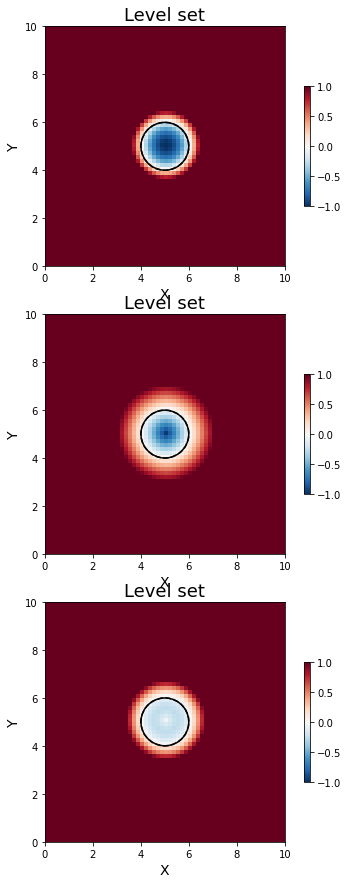

In [51]:
fig, ax = plt.subplots(figsize=(7,15),nrows=3)
c4 = ax[0].pcolormesh(np.unique(x_ls),np.unique(y_ls),Psi,cmap='RdBu_r',shading='auto',vmin=-1,vmax=1)
plt.colorbar(c4,ax=ax[0],shrink=0.5)
ax[0].set_xlabel('X',fontsize=14)
ax[0].set_ylabel('Y',fontsize=14)
ax[0].set_aspect('equal')
#x_ls_center = np.append(np.unique(x_ls)[:40],np.unique(x_ls)[41:])
#y_ls_center = np.unique(y_ls)
ax[0].contour(np.unique(x_ls),np.unique(y_ls),Psi,levels=[0],colors='k')
#ax.tricontour(x_ls,y_ls,Psi.flatten(),levels=np.arange(-1,1,0.05),colors='k',linewidths=0.5)
X,Y = np.meshgrid(x0,y0)
ax[0].tricontour(x0,y0,eval(ls1p.replace('x','x0').replace('y','y0')),levels=[0],colors='k',linestyles='dashed')
ax[0].set_title('Level set', fontsize=18);

c4 = ax[1].pcolormesh(np.unique(x_ls),np.unique(y_ls),d,cmap='RdBu_r',shading='auto',vmin=-1,vmax=1)
plt.colorbar(c4,ax=ax[1],shrink=0.5)
ax[1].set_xlabel('X',fontsize=14)
ax[1].set_ylabel('Y',fontsize=14)
ax[1].set_aspect('equal')
#x_ls_center = np.append(np.unique(x_ls)[:40],np.unique(x_ls)[41:])
#y_ls_center = np.unique(y_ls)
ax[1].contour(np.unique(x_ls),np.unique(y_ls),d,levels=[0],colors='k')
#ax.tricontour(x_ls,y_ls,Psi.flatten(),levels=np.arange(-1,1,0.05),colors='k',linewidths=0.5)
X,Y = np.meshgrid(x0,y0)
ax[1].tricontour(x0,y0,eval(ls1p.replace('x','x0').replace('y','y0')),levels=[0],colors='k',linestyles='dashed')
ax[1].set_title('Level set', fontsize=18);

c4 = ax[2].pcolormesh(np.unique(x_ls),np.unique(y_ls),Psi-d,cmap='RdBu_r',shading='auto',vmin=-1,vmax=1)
plt.colorbar(c4,ax=ax[2],shrink=0.5)
ax[2].set_xlabel('X',fontsize=14)
ax[2].set_ylabel('Y',fontsize=14)
ax[2].set_aspect('equal')
#x_ls_center = np.append(np.unique(x_ls)[:40],np.unique(x_ls)[41:])
#y_ls_center = np.unique(y_ls)
ax[2].contour(np.unique(x_ls),np.unique(y_ls),Psi,levels=[0],colors='k')
#ax.tricontour(x_ls,y_ls,Psi.flatten(),levels=np.arange(-1,1,0.05),colors='k',linewidths=0.5)
X,Y = np.meshgrid(x0,y0)
ax[2].tricontour(x0,y0,eval(ls1p.replace('x','x0').replace('y','y0')),levels=[0],colors='k',linestyles='dashed')
ax[2].set_title('Level set', fontsize=18);

Extension Velocity

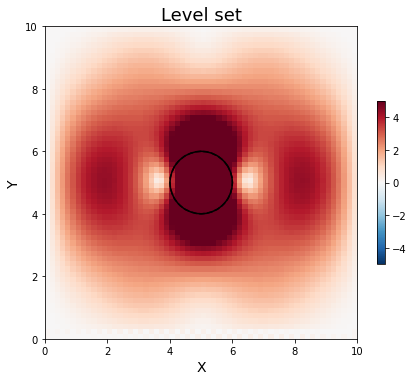

In [13]:
fig, ax = plt.subplots(figsize=(7,6))
dx = np.unique(x_ls)[1]-np.unique(x_ls)[0]
dy = np.unique(y_ls)[1]-np.unique(y_ls)[0]

u_ls = sciinterp.griddata(D_u[:,::2].transpose(), u[:,0], D.transpose(), method='linear')
v_ls = sciinterp.griddata(D_u[:,::2].transpose(), u[:,1], D.transpose(), method='linear')

d,fext = skfmm.extension_velocities(Psi,np.reshape(np.sqrt(u_ls**2+v_ls**2),Psi.shape),dx=[dx,dy])
c4 = ax.pcolormesh(np.unique(x_ls),np.unique(y_ls),np.reshape(np.sqrt(u_ls**2+v_ls**2),Psi.shape),cmap='RdBu_r',shading='auto',vmin=-5,vmax=5)
plt.colorbar(c4,ax=ax,shrink=0.5)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.set_aspect('equal')
#x_ls_center = np.append(np.unique(x_ls)[:40],np.unique(x_ls)[41:])
#y_ls_center = np.unique(y_ls)
ax.contour(np.unique(x_ls),np.unique(y_ls),Psi,levels=[0],colors='k')
#ax.tricontour(x_ls,y_ls,Psi.flatten(),levels=np.arange(-1,1,0.05),colors='k',linewidths=0.5)
X,Y = np.meshgrid(x0,y0)
ax.tricontour(x0,y0,eval(ls1p.replace('x','x0').replace('y','y0')),levels=[0],colors='k',linestyles='dashed')
ax.set_title('Level set', fontsize=18);

Temperature with free surface contour

ValueError: not enough values to unpack (expected 2, got 0)

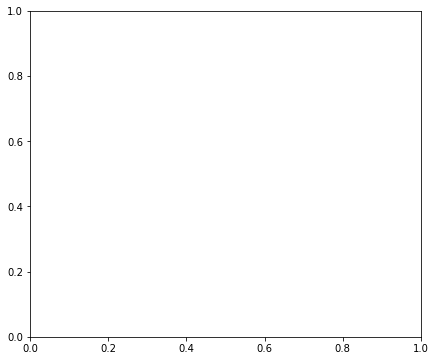

In [14]:
fig, ax = plt.subplots(figsize=(7,6))
c4 = ax.pcolormesh(np.unique(xt),np.unique(yt),T,cmap='RdBu_r',shading='auto')
plt.colorbar(c4,ax=ax,shrink=0.5)
ax.plot()
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.set_aspect('equal')
#x_ls_center = np.append(np.unique(x_ls)[:40],np.unique(x_ls)[41:])
#y_ls_center = np.unique(y_ls)
ax.contour(np.unique(x_ls),np.unique(y_ls),Psi,levels=[0],colors='k')
#ax.tricontour(x_ls,y_ls,Psi.flatten(),levels=np.arange(-1,1,0.05),colors='k',linewidths=0.5)
X,Y = np.meshgrid(x0,y0)
ax.tricontour(x0,y0,eval(ls1p.replace('x','x0').replace('y','y0')),levels=[0],colors='k',linestyles='dashed')
ax.set_title('Temperature', fontsize=18);

ax.quiver(np.unique(x)[::4],np.unique(y)[::4],ux[::4,::4],uy[::4,::4]);

ax.set_xlim(3,7)
ax.set_ylim(0,2)
ax.set_aspect('equal')

In [ ]:
import getfem as gf
import numpy as np
from scipy import rand,setdiff1d

eps = 1.0/40
ls_degree = 2

m = gf.Mesh('cartesian', np.arange(-.5,.5+eps,eps), np.arange(-.5,.5+eps,eps))
#m = gf.Mesh('triangles grid', np.arange(-.5,.5+eps,eps), np.arange(-.5,.5+eps,eps))
ls = gf.LevelSet(m,ls_degree)
#ls2 = gf.LevelSet(m, ls_degree, 'with_secondary')

mf_ls = ls.mf()
#mf_ls2 = ls2.mf()

P = mf_ls.basic_dof_nodes()
x = P[0,:]
y = P[1,:]
#ULS = ((x + 0.25)**2 + (y - 0.4)**2) - 0.05**2
#ULS = min(ULS, ((x - 0.25)**2 + (y - 0.4)**2) - 0.05**2)

ULS = 1000*np.ones(x.shape)

if True:
    for ix in range(0,5):
        for iy in range(0,5):
            xc = (ix/4) * 0.8 - 0.4
            yc = (iy/4) * 0.8 - 0.4
            if (iy%2)==1:
                xc = xc + 0.05
            else:
                xc = xc - 0.05
            R = 0.03 + 0.005*iy
            ULS = np.minimum(ULS, ((x - xc)**2 + (y - yc)**2) - R**2);
else:
    for i in range(8):
        xc = rand() - 0.5
        yc = rand() - 0.5
        R = rand() * 0.09 + 0.02
        ULS = np.minimum(ULS, ((x - xc)**2 + (y - yc)**2) - R**2);
ls.set_values(ULS)

ULS2 = 1000*np.ones(x.shape);
ULS2s = 1000*np.ones(x.shape);
for i in range(1):
    xc = 0.0 # rand() - 0.5
    yc = 0.0 # rand() - 0.5
    theta = np.pi/3 # np.pi*rand()
    n = [-np.sin(theta), np.cos(theta)]

    R = 0.19 #rand() * 0.09 + 0.02
    ULS2 = np.minimum(ULS2, ((x-xc)*n[0] + (y-yc)*n[1]))
    #ULS2s = np.minimum(ULS2s, ((x - xc)**2 + (y - yc)**2) - R**2)
    ULS2s = np.minimum(ULS2s, (abs(y - yc)+abs(x-xc) - R))

#ls2.set_values(ULS2, ULS2s) # '-y-x+.2') # '(y-.2)^2 - 0.04')

mls = gf.MeshLevelSet(m)
mls.add(ls)
#mls.add(ls2)
mls.adapt()
mls.cut_mesh().export_to_pos('ver.pos')

mim_bound = gf.MeshIm('levelset',mls,'boundary(a)', gf.Integ('IM_TRIANGLE(6)')) #, gf.Integ('IM_QUAD(5)'))
mim = gf.MeshIm('levelset',mls,'all(a)', gf.Integ('IM_TRIANGLE(6)'))
mim.set_integ(4)

mfu0 = gf.MeshFem(m,2)
mfu0.set_fem(gf.Fem('FEM_QK(2,3)'))

mfdu = gf.MeshFem(m,1)
mfdu.set_fem(gf.Fem('FEM_QK_DISCONTINUOUS(2,2)'))

mf_mult = gf.MeshFem(m,2)
mf_mult.set_fem(gf.Fem('FEM_QK(2,1)'))

A = gf.asm('volumic','V()+=comp()',mim_bound)

#mls.cut_mesh().export_to_pos('mls.pos','cut mesh')
#mf_ls.export_to_pos('mf_ls.pos',ULS,'ULS')

dof_out = mfu0.dof_from_im(mim)
cv_out = mim.convex_index()
cv_in = setdiff1d(m.cvid(),cv_out)

# mfu = gf.MeshFem('partial', mfu0, dof_out, cv_in)

md = gf.Model('real')
md.add_fem_variable('u', mfu0)
md.add_initialized_data('lambda', [1])
md.add_initialized_data('mu', [1])
md.add_isotropic_linearized_elasticity_brick(mim, 'u', 'lambda', 'mu')
md.add_initialized_data('VolumicData', [0, 10])
md.add_source_term_brick( mim, 'u', 'VolumicData')
md.add_multiplier('mult_dir', mf_mult, 'u')
md.add_Dirichlet_condition_with_multipliers(mim_bound, 'u', 'mult_dir', -1)
md.solve()

U = md.variable('u')
VM = md.compute_isotropic_linearized_Von_Mises_or_Tresca('u', 'lambda', 'mu', mfdu)

mfdu.export_to_vtk('vm.vtk', VM, 'Von Mises', mfu0, U, 'deformation')
mf_ls.export_to_vtk('ls.vtk',ls.values(0),'ls values 0')

#print('You can view the solution with (for instance):')
#print('gmsh vm.pos ls.pos')